In [ ]:
#from https://thinkingneuron.com/using-artificial-neural-networks-for-regression-in-python/

import pandas as pd
import seaborn as sns
from sklearn.neural_network import MLPRegressor
import itertools
from sklearn.model_selection import cross_validate, RandomizedSearchCV, train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
import pickle
df = pd.read_csv("../PreProcessamentoDados/cleanedData.csv")

In [ ]:
df[['Hour','Minute','Second']] = df.DateTime.str.split(":",expand=True)

In [ ]:
df.head()

In [ ]:
df.dtypes

In [ ]:
# define a dictionary of column names and their corresponding data types
dtypes_dict = {'Hour': float, 'Minute': float}

# convert the columns to their corresponding data types
df = df.astype(dtypes_dict)

In [ ]:
df.head()

In [ ]:
# Separate Target Variable and Predictor Variables
TargetVariable = ["Generated power"]
Predictors= ["Hour","Minute","TemperatureC","DewpointC","PressurehPa","WindDirectionDegrees","WindSpeedKMH","WindSpeedGustKMH","Humidity","HourlyPrecipMM","dailyrainMM","SolarRadiationWatts_m2"]

X=df[Predictors].values
y=df[TargetVariable].values

In [ ]:
# check if the array has any negative values
if (y < 0).any():
    print('The array has negative values.')
else:
    print('The array does not have negative values.')

In [ ]:
# y = df['generated_power'].values
# X = df.drop(columns=['generated_power']).values

In [ ]:
# y = y.reshape(-1,1)


In [ ]:
### Standardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)


In [ ]:
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)
 

In [ ]:
# check if the array has any negative values
if (y < 0).any():
    print('The array has negative values.')
else:
    print('The array does not have negative values.')

In [ ]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
 
# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=12, kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

In [ ]:

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error','mean_absolute_error'])

In [ ]:
# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 20, epochs = 50, verbose=1)

# Hyperparameter tuning of ANN


# Finding best set of parameters using manual grid search


In [13]:
import numpy as np

# Defining a function to find the best parameters for ANN
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list=[5, 10, 15, 20]
    epoch_list  =   [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData=pd.DataFrame(columns=['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber=0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber+=1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units=5, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))

            # Defining the Second layer of the model
            model.add(Dense(units=5, kernel_initializer='normal', activation='relu'))

            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer='normal'))

            # Compiling the model
            model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_absolute_error'])

            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=1)

            mean_squared_error, mean_absolute_error = model.evaluate(X_test,y_test)

            # print("y_test: ",y_test)
            predictions = model.predict(X_test)
            # print("model.predict(X_test)",predictions)
            MAPE = np.mean(100 * (np.abs(y_test-predictions)/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:',epochs_trial, 'MAPE:',MAPE,'Accuracy:', 100-MAPE,'mean_squared_error: ',mean_squared_error,
                  'mean_absolute_error: ',mean_absolute_error)
            
            SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],
                                                                    columns=['TrialNumber', 'Parameters', 'Accuracy','mean_squared_error','mean_absolute_error'] ))
    return(SearchResultsData)


######################################################
# Calling the function
ResultsData=FunctionFindBestParams(X_train, y_train, X_test, y_test)

Epoch 1/5
8871/8871 [==============================] - 11s 1ms/step - loss: 0.1904 - mean_absolute_error: 0.2483
Epoch 2/5
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1453 - mean_absolute_error: 0.2100
Epoch 3/5
8871/8871 [==============================] - 11s 1ms/step - loss: 0.1387 - mean_absolute_error: 0.2043
Epoch 4/5
8871/8871 [==============================] - 11s 1ms/step - loss: 0.1336 - mean_absolute_error: 0.1991
Epoch 5/5
594/594 [==============================] - 1s 948us/step
1 Parameters: batch_size: 5 - epochs: 5 MAPE: 63.94066462527907 Accuracy: 36.05933537472093 mean_squared_error:  0.133893221616745 mean_absolute_error:  0.20499874651432037
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


8871/8871 [==============================] - 11s 1ms/step - loss: 0.2152 - mean_absolute_error: 0.2879
Epoch 2/10
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1668 - mean_absolute_error: 0.2281
Epoch 3/10
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1520 - mean_absolute_error: 0.2120
Epoch 4/10
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1407 - mean_absolute_error: 0.1971
Epoch 5/10
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1369 - mean_absolute_error: 0.1933
Epoch 6/10
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1350 - mean_absolute_error: 0.1918
Epoch 7/10
8871/8871 [==============================] - 11s 1ms/step - loss: 0.1341 - mean_absolute_error: 0.1914
Epoch 8/10
8871/8871 [==============================] - 11s 1ms/step - loss: 0.1341 - mean_absolute_error: 0.1919
Epoch 9/10
8871/8871 [==============================] - 11s 1ms/step - loss: 0.1340 - mean_absolute

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


8871/8871 [==============================] - 11s 1ms/step - loss: 0.1912 - mean_absolute_error: 0.2497
Epoch 2/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1435 - mean_absolute_error: 0.2129
Epoch 3/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1377 - mean_absolute_error: 0.2050
Epoch 4/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1334 - mean_absolute_error: 0.1977
Epoch 5/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1309 - mean_absolute_error: 0.1939
Epoch 6/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1289 - mean_absolute_error: 0.1920
Epoch 7/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1272 - mean_absolute_error: 0.1908
Epoch 8/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1268 - mean_absolute_error: 0.1909
Epoch 9/50
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1262 - mean_absolute

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


8871/8871 [==============================] - 11s 1ms/step - loss: 0.1960 - mean_absolute_error: 0.2547
Epoch 2/100
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1497 - mean_absolute_error: 0.2155
Epoch 3/100
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1390 - mean_absolute_error: 0.2075
Epoch 4/100
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1344 - mean_absolute_error: 0.2005
Epoch 5/100
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1323 - mean_absolute_error: 0.1981
Epoch 6/100
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1314 - mean_absolute_error: 0.1971
Epoch 7/100
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1308 - mean_absolute_error: 0.1966
Epoch 8/100
8871/8871 [==============================] - 10s 1ms/step - loss: 0.1303 - mean_absolute_error: 0.1955
Epoch 9/100
8871/8871 [==============================] - 11s 1ms/step - loss: 0.1297 - mean_

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 5s 1ms/step - loss: 0.2258 - mean_absolute_error: 0.2713
Epoch 2/5
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1489 - mean_absolute_error: 0.2214
Epoch 3/5
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1393 - mean_absolute_error: 0.2046
Epoch 4/5
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1365 - mean_absolute_error: 0.1998
Epoch 5/5
594/594 [==============================] - 1s 917us/step
5 Parameters: batch_size: 10 - epochs: 5 MAPE: 67.50155142860936 Accuracy: 32.49844857139064 mean_squared_error:  0.13214004039764404 mean_absolute_error:  0.18868060410022736
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 5s 1ms/step - loss: 0.2282 - mean_absolute_error: 0.2790
Epoch 2/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1546 - mean_absolute_error: 0.2195
Epoch 3/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1404 - mean_absolute_error: 0.2062
Epoch 4/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1363 - mean_absolute_error: 0.2021
Epoch 5/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1346 - mean_absolute_error: 0.2012
Epoch 6/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1341 - mean_absolute_error: 0.2002
Epoch 7/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1333 - mean_absolute_error: 0.1992
Epoch 8/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1332 - mean_absolute_error: 0.1988
Epoch 9/10
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1327 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 5s 1ms/step - loss: 0.2189 - mean_absolute_error: 0.2730
Epoch 2/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1666 - mean_absolute_error: 0.2396
Epoch 3/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1502 - mean_absolute_error: 0.2189
Epoch 4/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1385 - mean_absolute_error: 0.2032
Epoch 5/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1347 - mean_absolute_error: 0.1986
Epoch 6/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1329 - mean_absolute_error: 0.1971
Epoch 7/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1314 - mean_absolute_error: 0.1963
Epoch 8/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1308 - mean_absolute_error: 0.1958
Epoch 9/50
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1303 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


4436/4436 [==============================] - 5s 1ms/step - loss: 0.2248 - mean_absolute_error: 0.2605
Epoch 2/100
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1477 - mean_absolute_error: 0.2145
Epoch 3/100
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1408 - mean_absolute_error: 0.2090
Epoch 4/100
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1369 - mean_absolute_error: 0.2044
Epoch 5/100
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1354 - mean_absolute_error: 0.2024
Epoch 6/100
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1344 - mean_absolute_error: 0.2016
Epoch 7/100
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1339 - mean_absolute_error: 0.2015
Epoch 8/100
4436/4436 [==============================] - 5s 1ms/step - loss: 0.1337 - mean_absolute_error: 0.2015
Epoch 9/100
4436/4436 [==============================] - 6s 1ms/step - loss: 0.1337 - mean_absolute_

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 5s 1ms/step - loss: 0.2281 - mean_absolute_error: 0.2802
Epoch 2/5
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1514 - mean_absolute_error: 0.2171
Epoch 3/5
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1398 - mean_absolute_error: 0.2039
Epoch 4/5
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1351 - mean_absolute_error: 0.1987
Epoch 5/5
594/594 [==============================] - 1s 1ms/step
9 Parameters: batch_size: 15 - epochs: 5 MAPE: 63.71067833138498 Accuracy: 36.28932166861502 mean_squared_error:  0.13316786289215088 mean_absolute_error:  0.1920527219772339
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 4s 1ms/step - loss: 0.2392 - mean_absolute_error: 0.2745
Epoch 2/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1479 - mean_absolute_error: 0.2114
Epoch 3/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1412 - mean_absolute_error: 0.2070
Epoch 4/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1376 - mean_absolute_error: 0.2033
Epoch 5/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1351 - mean_absolute_error: 0.1984
Epoch 6/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1325 - mean_absolute_error: 0.1926
Epoch 7/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1309 - mean_absolute_error: 0.1908
Epoch 8/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1301 - mean_absolute_error: 0.1903
Epoch 9/10
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1289 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 4s 1ms/step - loss: 0.2387 - mean_absolute_error: 0.2830
Epoch 2/50
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1612 - mean_absolute_error: 0.2276
Epoch 3/50
2957/2957 [==============================] - 4s 2ms/step - loss: 0.1476 - mean_absolute_error: 0.2180
Epoch 4/50
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1414 - mean_absolute_error: 0.2131
Epoch 5/50
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1380 - mean_absolute_error: 0.2087
Epoch 6/50
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1361 - mean_absolute_error: 0.2067
Epoch 7/50
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1355 - mean_absolute_error: 0.2051
Epoch 8/50
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1345 - mean_absolute_error: 0.2040
Epoch 9/50
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1341 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2957/2957 [==============================] - 4s 1ms/step - loss: 0.2476 - mean_absolute_error: 0.2848
Epoch 2/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1677 - mean_absolute_error: 0.2372
Epoch 3/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1579 - mean_absolute_error: 0.2298
Epoch 4/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1478 - mean_absolute_error: 0.2216
Epoch 5/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1401 - mean_absolute_error: 0.2088
Epoch 6/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1365 - mean_absolute_error: 0.2053
Epoch 7/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1349 - mean_absolute_error: 0.2041
Epoch 8/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1336 - mean_absolute_error: 0.2032
Epoch 9/100
2957/2957 [==============================] - 4s 1ms/step - loss: 0.1329 - mean_absolute_

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 3s 1ms/step - loss: 0.2738 - mean_absolute_error: 0.2975
Epoch 2/5
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1555 - mean_absolute_error: 0.2294
Epoch 3/5
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1437 - mean_absolute_error: 0.2124
Epoch 4/5
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1387 - mean_absolute_error: 0.2023
Epoch 5/5
594/594 [==============================] - 1s 943us/step
13 Parameters: batch_size: 20 - epochs: 5 MAPE: 68.90502159483778 Accuracy: 31.094978405162223 mean_squared_error:  0.1338081806898117 mean_absolute_error:  0.20296421647071838
Epoch 1/10


C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 3s 1ms/step - loss: 0.2877 - mean_absolute_error: 0.3021
Epoch 2/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1603 - mean_absolute_error: 0.2303
Epoch 3/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1474 - mean_absolute_error: 0.2172
Epoch 4/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1418 - mean_absolute_error: 0.2110
Epoch 5/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1389 - mean_absolute_error: 0.2074
Epoch 6/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1374 - mean_absolute_error: 0.2057
Epoch 7/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1364 - mean_absolute_error: 0.2029
Epoch 8/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1356 - mean_absolute_error: 0.2007
Epoch 9/10
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1348 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 3s 1ms/step - loss: 0.2597 - mean_absolute_error: 0.2972
Epoch 2/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1503 - mean_absolute_error: 0.2154
Epoch 3/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1388 - mean_absolute_error: 0.2039
Epoch 4/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1340 - mean_absolute_error: 0.1980
Epoch 5/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1324 - mean_absolute_error: 0.1958
Epoch 6/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1311 - mean_absolute_error: 0.1943
Epoch 7/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1298 - mean_absolute_error: 0.1930
Epoch 8/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1291 - mean_absolute_error: 0.1924
Epoch 9/50
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1282 - mean_absolute_error: 0

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


2218/2218 [==============================] - 3s 1ms/step - loss: 0.2470 - mean_absolute_error: 0.2914
Epoch 2/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1513 - mean_absolute_error: 0.2154
Epoch 3/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1396 - mean_absolute_error: 0.2058
Epoch 4/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1352 - mean_absolute_error: 0.2019
Epoch 5/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1327 - mean_absolute_error: 0.1981
Epoch 6/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1312 - mean_absolute_error: 0.1951
Epoch 7/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1297 - mean_absolute_error: 0.1932
Epoch 8/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1295 - mean_absolute_error: 0.1927
Epoch 9/100
2218/2218 [==============================] - 3s 1ms/step - loss: 0.1288 - mean_absolute_

C:\Users\rafae\AppData\Local\Temp\ipykernel_17804\3612813780.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SearchResultsData=SearchResultsData.append(pd.DataFrame(data=[[TrialNumber, str(batch_size_trial)+'-'+str(epochs_trial), 100-MAPE,mean_squared_error,mean_absolute_error]],


<AxesSubplot:xlabel='Parameters'>

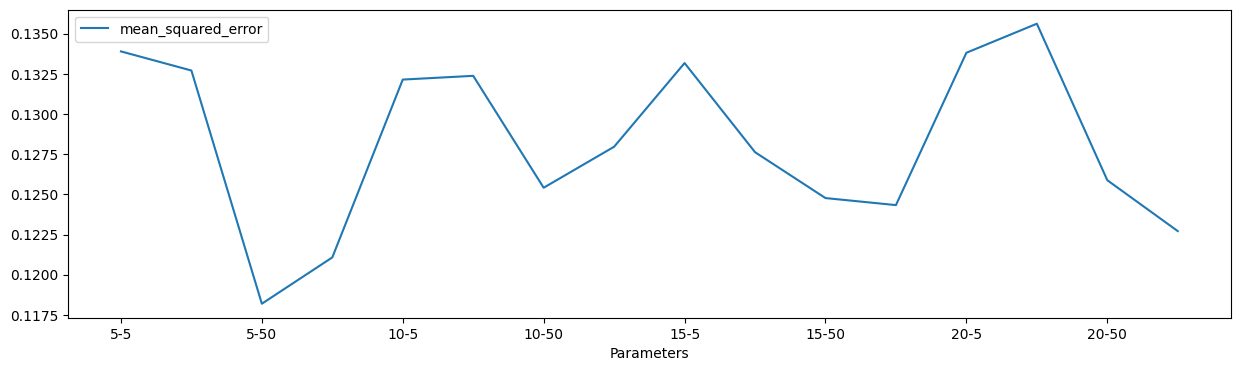

In [22]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='mean_squared_error',figsize=(15,4), kind='line')

<AxesSubplot:xlabel='Parameters'>

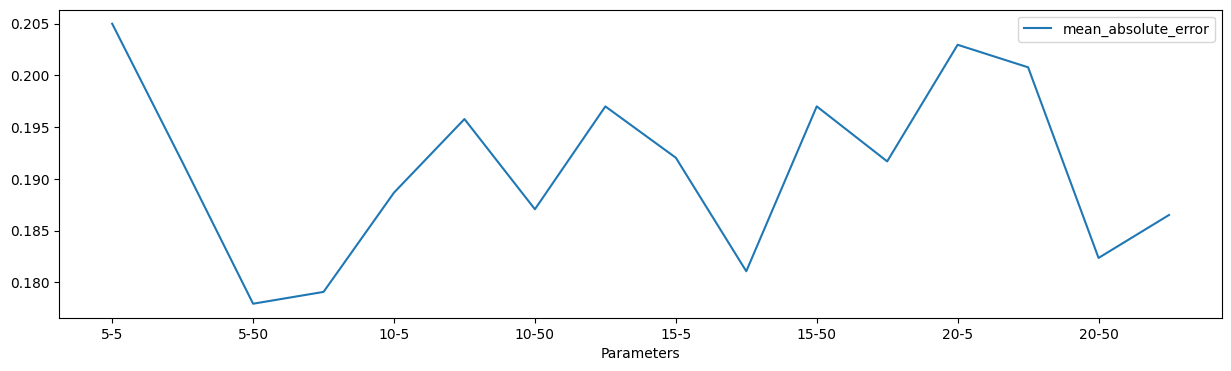

In [27]:
%matplotlib inline
ResultsData.plot(x='Parameters', y='mean_absolute_error',figsize=(15,4), kind='line')

In [ ]:

# importing package
import matplotlib.pyplot as plt
import numpy as np

x = ResultsData["Parameters"]  

# plot lines
plt.plot(x, ResultsData["mean_squared_error"], label = "mean squared")
plt.plot(ResultsData["Parameters"], ResultsData["mean_absolute_error"], label = "mean absolute")
plt.legend()
plt.show()

In [14]:
ResultsData

,TrialNumber,Parameters,Accuracy,mean_squared_error,mean_absolute_error
0,1,5-5,36.059335,0.133893,0.204999
0,2,5-10,50.302987,0.132703,0.191578
0,3,5-50,43.722767,0.118194,0.177947
0,4,5-100,45.035764,0.121075,0.179089
0,5,10-5,32.498449,0.132140,0.188681
0,6,10-10,46.346114,0.132372,0.195787
0,7,10-50,30.569397,0.125411,0.187076
0,8,10-100,43.493309,0.127961,0.197009
0,9,15-5,36.289322,0.133168,0.192053
0,10,15-10,31.301259,0.127623,0.181083


In [16]:
ResultsData.to_csv('ResultsData.csv', index=False)


In [17]:
ResultsDataPlot = ResultsData


In [18]:
ResultsDataPlot

,TrialNumber,Parameters,Accuracy,mean_squared_error,mean_absolute_error
0,1,5-5,36.059335,0.133893,0.204999
0,2,5-10,50.302987,0.132703,0.191578
0,3,5-50,43.722767,0.118194,0.177947
0,4,5-100,45.035764,0.121075,0.179089
0,5,10-5,32.498449,0.132140,0.188681
0,6,10-10,46.346114,0.132372,0.195787
0,7,10-50,30.569397,0.125411,0.187076
0,8,10-100,43.493309,0.127961,0.197009
0,9,15-5,36.289322,0.133168,0.192053
0,10,15-10,31.301259,0.127623,0.181083


In [ ]:
ResultsDataPlot["Accuracy"] = ResultsDataPlot["Accuracy"].add(100)

In [ ]:
ResultsDataPlot["Accuracy"] = ResultsDataPlot["Accuracy"].multiply(-1)


In [ ]:
ResultsDataPlot

<AxesSubplot:xlabel='Parameters'>

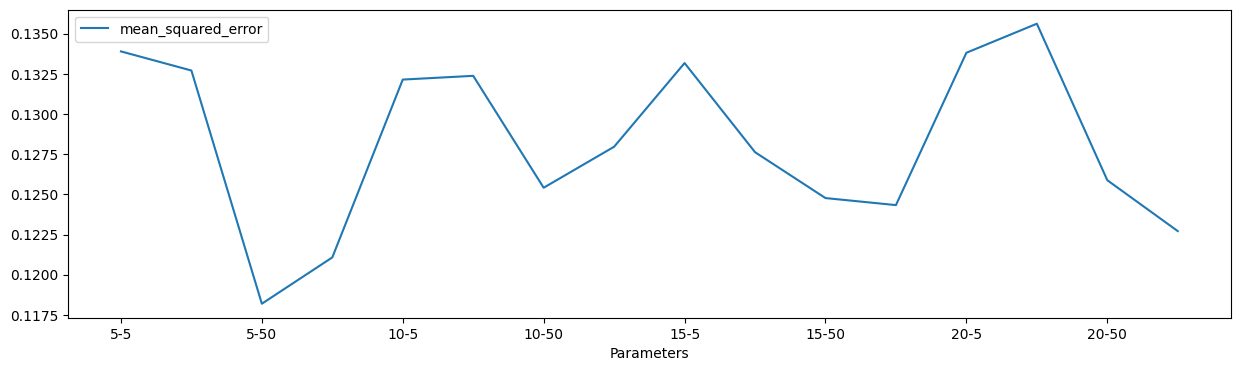

In [20]:
%matplotlib inline
ResultsDataPlot.plot(x='Parameters', y='mean_squared_error', figsize=(15,4), kind='line')

# Training the ANN model with the best parameters


In [ ]:
# Fitting the ANN to the Training set
history=model.fit(
    X_train, 
    y_train ,
    batch_size = 15, 
    epochs = 5,     
    verbose=1,
    validation_split = 0.33)

In [ ]:
# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Generation']=y_test_orig
TestingData['PredictedGeneration']=Predictions
TestingData.head()

In [ ]:
# filter rows where column1 is equal to column2
filtered_data = TestingData.loc[TestingData['Generation'] == TestingData['PredictedGeneration']]

print(filtered_data)

In [ ]:
TestingData

# Save and Evaluation

In [ ]:
filename = './DNN_finalized_model'


In [ ]:
# save the model to disk
model.save(filename)

In [ ]:
import tensorflow as tf

# load the model from disk
model = tf.keras.models.load_model(filename)

In [ ]:
print(type(model))

In [ ]:
# Fitting the ANN to the Training set
history=model.fit(
    X_train,
    y_train, 
    batch_size = 15,
    epochs = 5,
    verbose=1,
    validation_split = 0.33)


In [ ]:

# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['Generation']=y_test_orig
TestingData['PredictedGeneration']=Predictions
TestingData.head()

In [ ]:
model.summary()

# Explainable AI Shap

In [ ]:
import shap
explainer = shap.DeepExplainer(model,X_train)

shap_values = explainer.shap_values(X_train)

In [ ]:
import shap
explainer = shap.DeepExplainer(model,X_test)

shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values,X_test)

In [ ]:
print(shap.__version__)
print(tf.__version__)


In [ ]:
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
plot_loss(history)